In [1]:
# %load imports.txt
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../../../')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Imports & Constants

In [2]:
import os
from collections import defaultdict

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from pyro.infer.autoguide import AutoDelta
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score

from src.learning.svi import train_svi
from src.models.graphical.bayesian_network import BayesianNetwork
from src.datasets.load_datasets import load_discrete_for_bayesian_network
from src.datasets.prepare_data import prepare_data_for_bayesian_network
from src.visualizations.plots import visualize_bayesian_network
from src.predictors.svi_predictor import predict
from src.experiments.base_experiment import k_fold_experiment
from src.settings import DATA_DIR, REPORT_DIR, RESULT_DIR

In [3]:
DISCRETE_DATASET_PATH = os.path.join(DATA_DIR, 'datasets', 'diabetes-discrete.csv')
DISCRETE_MISSING_VALUES_DATASET_PATH = os.path.join(DATA_DIR, 'datasets', 'diabetes-discrete-missing-values.csv')

PLOT_PATH = os.path.join(REPORT_DIR, 'figures', 'bayesian-network')

# Experiments

In [4]:
X = load_discrete_for_bayesian_network(DISCRETE_DATASET_PATH)
SAVE_NAME = 'discrete'

# X = load_discrete_for_bayesian_network(DISCRETE_MISSING_VALUES_DATASET_PATH)
# SAVE_NAME = 'discrete-missing'

In [5]:
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True)
X_train, X_test = prepare_data_for_bayesian_network(X_train, X_test)

In [6]:
clf = BayesianNetwork()
history = train_svi(clf.model, clf.guide, X_train, 0.001, num_epochs=1_000)

Epoch = 0, Loss = 4255.9246826171875
Epoch = 50, Loss = 4017.0042724609375
Epoch = 100, Loss = 3919.890594482422
Epoch = 150, Loss = 3876.2252807617188
Epoch = 200, Loss = 3855.1991577148438
Epoch = 250, Loss = 3844.304931640625
Epoch = 300, Loss = 3838.2440490722656
Epoch = 350, Loss = 3834.6810913085938
Epoch = 400, Loss = 3832.5040588378906
Epoch = 450, Loss = 3831.1356506347656
Epoch = 500, Loss = 3830.2540893554688
Epoch = 550, Loss = 3829.6727600097656
Epoch = 600, Loss = 3829.2791748046875
Epoch = 650, Loss = 3829.00634765625
Epoch = 700, Loss = 3828.8118591308594
Epoch = 750, Loss = 3828.6697387695312
Epoch = 800, Loss = 3828.5634155273438
Epoch = 850, Loss = 3828.482452392578
Epoch = 900, Loss = 3828.419677734375
Epoch = 950, Loss = 3828.3702392578125
Epoch = 999, Loss = 3828.331573486328


In [7]:
pred_summary = predict(clf.model, clf.guide, X_test, return_sites=("Outcome", ))
pred = (pred_summary['Outcome']['mean'] > .3).float().numpy()

In [8]:
print('Accuracy:', accuracy_score(X_test.O.numpy(), pred))
print('F1-score:', f1_score(X_test.O.numpy(), pred))

Accuracy: 0.7077922077922078
F1-score: 0.6511627906976745


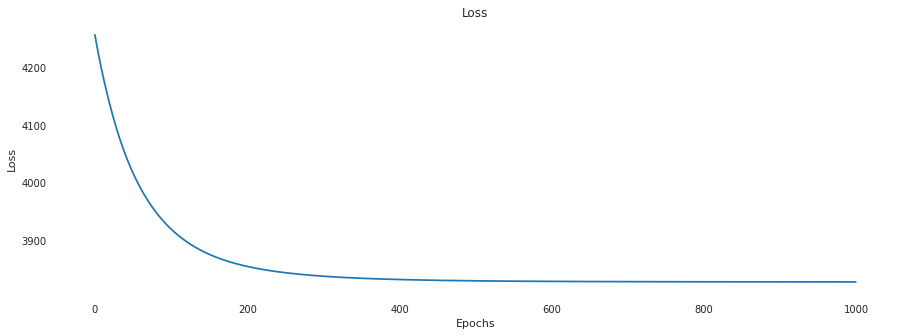

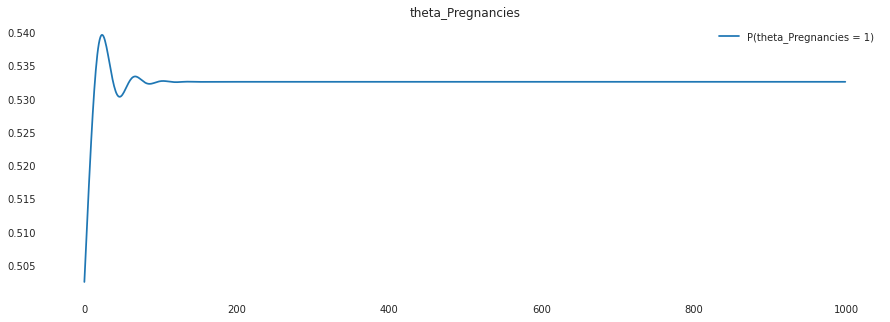

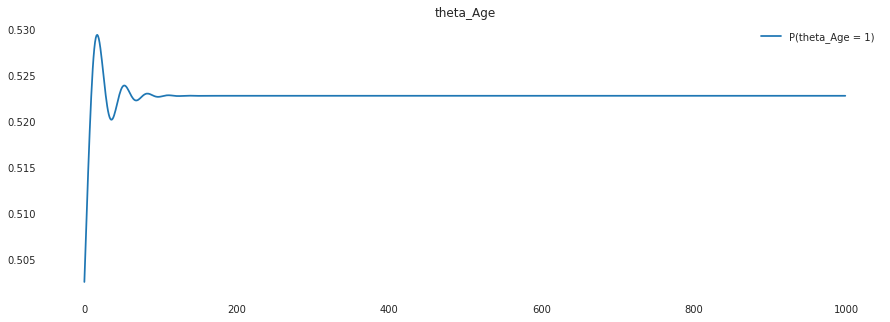

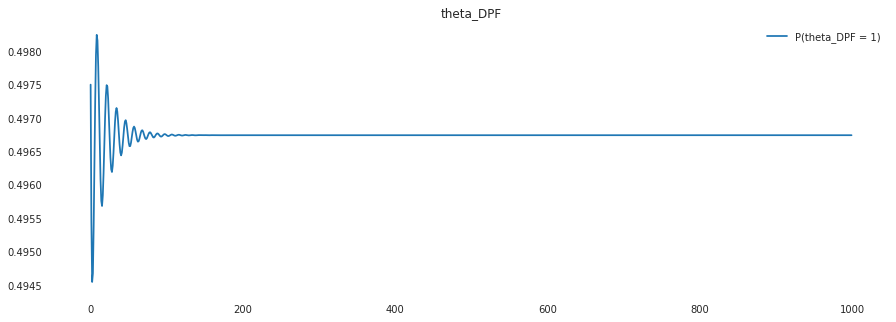

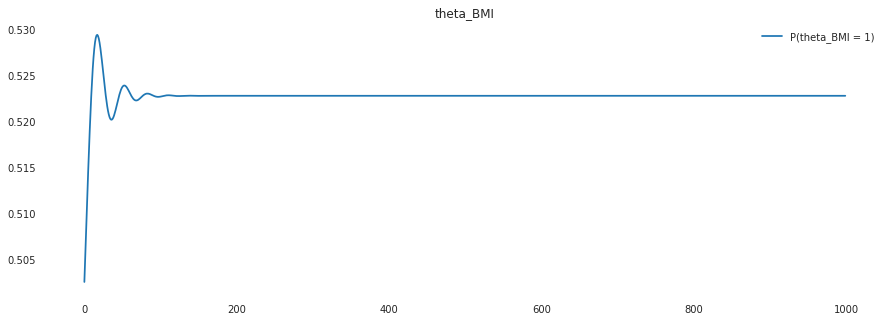

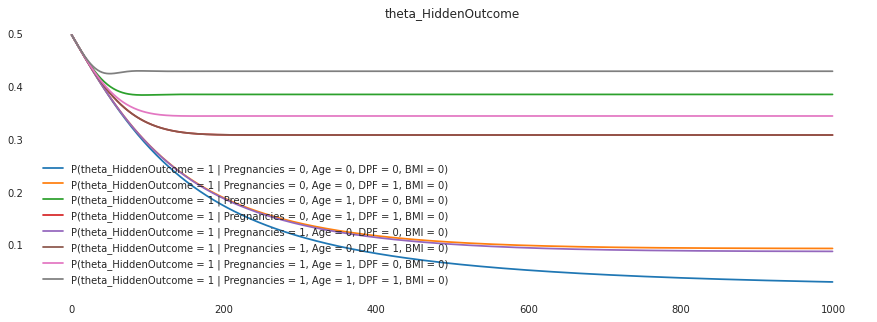

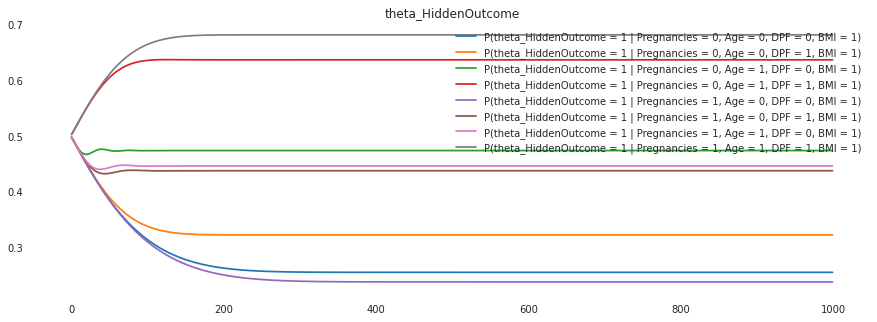

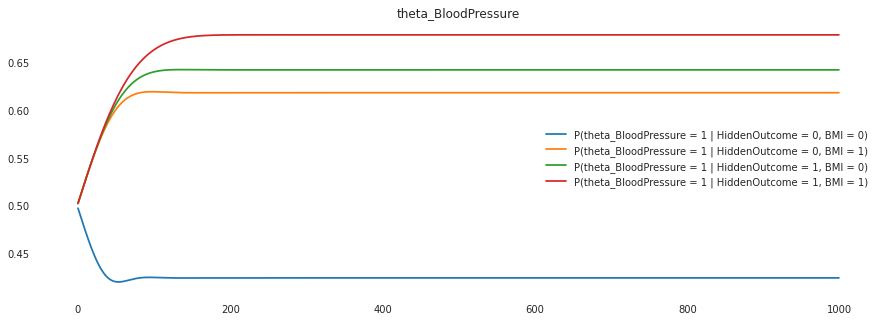

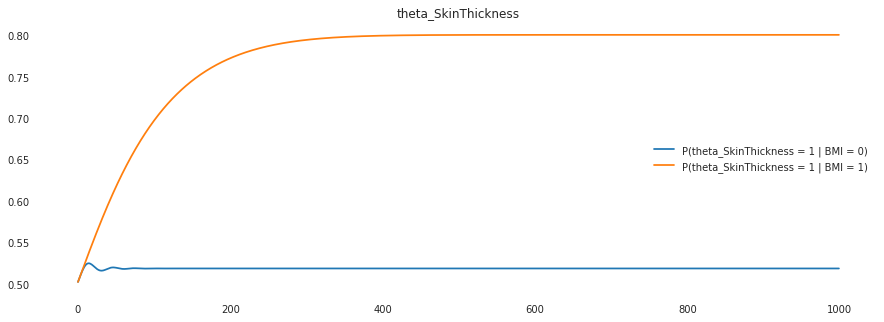

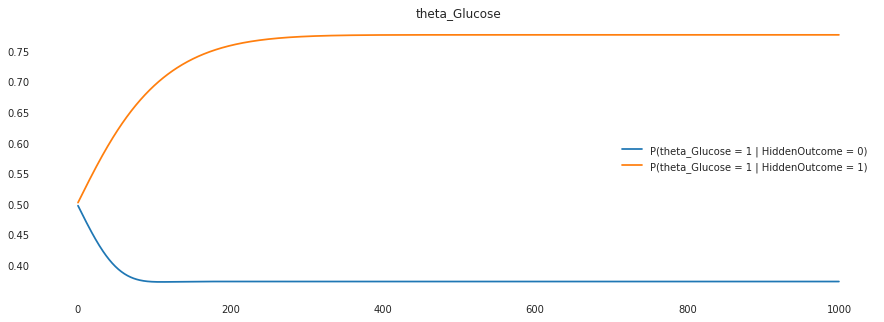

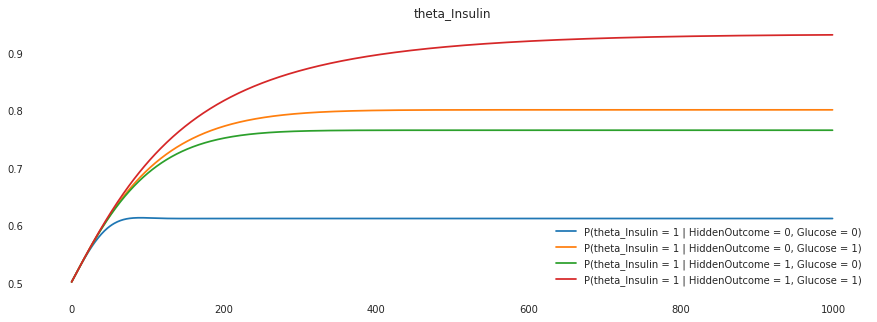

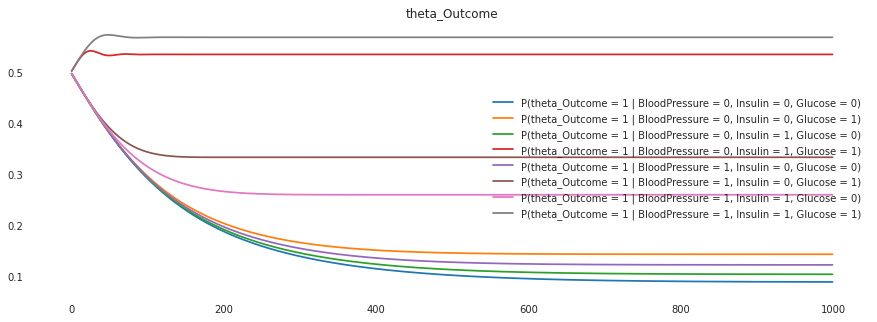

In [9]:
visualize_bayesian_network(history, f'{PLOT_PATH}/{SAVE_NAME}_')

### Score test

In [10]:
def train_func(X_train, y_train, X_test, y_test, threshold = .5, confidence_range = None):
    X_train, X_test = prepare_data_for_bayesian_network(X_train, X_test)
    
    clf = BayesianNetwork()
    history = train_svi(clf.model, clf.guide, X_train, 0.001, num_epochs=1_000, interval=np.inf)
    
    pred_summary = predict(clf.model, clf.guide, X_test, return_sites=("Outcome", ))
    
    results = pd.DataFrame()
    results['Mean'] = pred_summary['Outcome']['mean']
    results['Prediction'] = (pred_summary['Outcome']['mean'] >= threshold).float().numpy()
    results['Std'] = pred_summary['Outcome']['std']
    results['LowerConfidence'] = pred_summary['Outcome']['lower_confidence']
    results['UpperConfidence'] = pred_summary['Outcome']['upper_confidence']
    results['ConfidenceRange'] = pred_summary['Outcome']['confidence_range']
    results['True'] = X_test.O.numpy()
    
    if confidence_range is not None:
        results = results[(results.ConfidenceRange < confidence_range)]
    
    y_pred = results['Prediction']
    y_true = results['True']
    
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'ConfusionMatrix': confusion_matrix(y_true, y_pred),
    }

In [11]:
history = k_fold_experiment(
    lambda x1, y1, x2, y2: train_func(
        x1, y1, x2, y2,
        threshold = .3,
        confidence_range = None
    ),
    X,
    X[:, -1],
    n_splits=5,
)
history

Epoch = 0, Loss = 4255.9246826171875
Epoch = 999, Loss = 3818.9244079589844
Epoch = 0, Loss = 4255.9246826171875
Epoch = 999, Loss = 3832.8558044433594
Epoch = 0, Loss = 4255.9246826171875
Epoch = 999, Loss = 3834.4356689453125
Epoch = 0, Loss = 4262.856140136719
Epoch = 999, Loss = 3828.3746643066406
Epoch = 0, Loss = 4262.856140136719
Epoch = 999, Loss = 3842.024200439453


[{'Accuracy': 0.6753246753246753,
  'F1-score': 0.609375,
  'Recall': 0.7222222222222222,
  'Precision': 0.527027027027027,
  'ConfusionMatrix': array([[65, 35],
         [15, 39]])},
 {'Accuracy': 0.7207792207792207,
  'F1-score': 0.6446280991735538,
  'Recall': 0.7222222222222222,
  'Precision': 0.582089552238806,
  'ConfusionMatrix': array([[72, 28],
         [15, 39]])},
 {'Accuracy': 0.7467532467532467,
  'F1-score': 0.6722689075630253,
  'Recall': 0.7407407407407407,
  'Precision': 0.6153846153846154,
  'ConfusionMatrix': array([[75, 25],
         [14, 40]])},
 {'Accuracy': 0.673202614379085,
  'F1-score': 0.6031746031746031,
  'Recall': 0.7169811320754716,
  'Precision': 0.5205479452054794,
  'ConfusionMatrix': array([[65, 35],
         [15, 38]])},
 {'Accuracy': 0.6601307189542484,
  'F1-score': 0.6176470588235294,
  'Recall': 0.7924528301886793,
  'Precision': 0.5060240963855421,
  'ConfusionMatrix': array([[59, 41],
         [11, 42]])}]

In [12]:
avg_metrics = defaultdict(list)

for h in history:
    for k in h:
        avg_metrics[k].append(h[k])


for k in avg_metrics:
    print(k, np.mean(avg_metrics[k]), np.std(avg_metrics[k]))


Accuracy 0.6952380952380952 0.03292656832531491
F1-score 0.6294187337469423 0.025676994276073416
Recall 0.7389238294898671 0.02795719736587343
Precision 0.5502146472482939 0.04155410459201263
ConfusionMatrix 38.4 19.533048917155764
